## AI & Machine Learning for Data Quality
**Description**: AI and machine learning can automate and enhance data quality checks by learning patterns and identifying anomalies more effectively than static rules.

**Task 1**: Training a model to predict and flag unusual trend patterns in sales data that
deviate from historical norms.

/tmp/ipykernel_17001/1555941474.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['RollingMean'] = df['Sales'].rolling(window=7, center=True).mean().fillna(method='bfill').fillna(method='ffill')


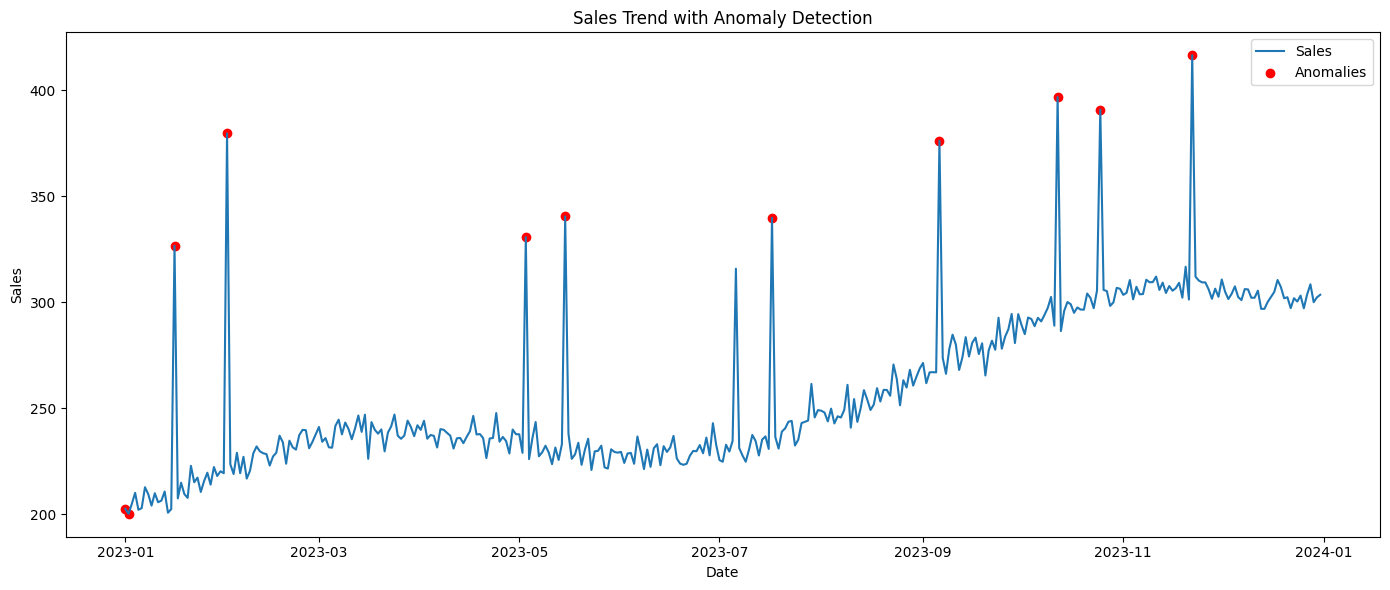

🔍 Anomalies detected on these dates:
          Date       Sales
0   2023-01-01  202.483571
1   2023-01-02  200.101191
15  2023-01-16  326.533157
31  2023-02-01  379.566028
122 2023-05-03  330.613532
134 2023-05-15  340.414979
197 2023-07-17  339.790942
248 2023-09-06  376.116682
284 2023-10-12  396.678843
297 2023-10-25  390.824984
325 2023-11-22  416.453750


In [4]:
# write your code from here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. Generate mock historical sales data
np.random.seed(42)
days = pd.date_range(start='2023-01-01', periods=365)
trend = np.linspace(200, 300, num=365)  # increasing trend
seasonality = 20 * np.sin(np.linspace(0, 3 * np.pi, 365))  # seasonal pattern
noise = np.random.normal(0, 5, size=365)  # random noise

sales = trend + seasonality + noise

# Inject anomalies
anomalies_indices = np.random.choice(365, size=10, replace=False)
sales[anomalies_indices] += np.random.normal(100, 30, size=10)  # spike anomalies

# Create DataFrame
df = pd.DataFrame({'Date': days, 'Sales': sales})
df['DayOfYear'] = df['Date'].dt.dayofyear
df['RollingMean'] = df['Sales'].rolling(window=7, center=True).mean().fillna(method='bfill').fillna(method='ffill')

# 2. Use Isolation Forest to detect anomalies
model = IsolationForest(contamination=0.03, random_state=42)
df['Anomaly'] = model.fit_predict(df[['Sales', 'DayOfYear', 'RollingMean']])
df['Anomaly'] = df['Anomaly'].map({1: 0, -1: 1})  # Convert to 0=normal, 1=anomaly

# 3. Plot the results
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Sales'], label='Sales')
plt.scatter(df[df['Anomaly'] == 1]['Date'], df[df['Anomaly'] == 1]['Sales'], color='red', label='Anomalies')
plt.title('Sales Trend with Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Print anomaly dates
print("🔍 Anomalies detected on these dates:")
print(df[df['Anomaly'] == 1][['Date', 'Sales']])

**Task 2**: Using clustering algorithms to detect duplicate records where entries are not
exactly identical.

In [5]:
# write your code from here

import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack

# 1. Sample dataset simulating slightly different duplicate records
data = {
    'Name': [
        'John Doe', 'Jon Doe', 'Jane Smith', 'Janet Smith', 'Jake Long',
        'Jack Long', 'John Doe', 'J0hn Do', 'Jane Smyth', 'Jake L0ng'
    ],
    'Email': [
        'john@example.com', 'jon@example.com', 'jane.smith@example.com', 'janet@example.com',
        'jake.long@example.com', 'jack.long@example.com', 'john.doe@example.com',
        'john@example.com', 'jane.s@example.com', 'jake@example.com'
    ],
    'Phone': [
        '555-1234', '555-1234', '555-5678', '555-5678', '555-8765',
        '555-8766', '555-1234', '555-1234', '555-5678', '555-8765'
    ]
}

df = pd.DataFrame(data)

# 2. Convert categorical/text fields to numeric features
# Vectorize names and emails with TF-IDF
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,4))  # char ngrams for fuzzy similarity
name_vec = vectorizer.fit_transform(df['Name'])
email_vec = vectorizer.fit_transform(df['Email'])

# 3. Encode phone numbers (simple numeric encoding after removing non-digits)
df['Phone_Num'] = df['Phone'].str.replace(r'\D', '', regex=True).astype(int).values.reshape(-1, 1)

# 4. Combine all features into one feature matrix
from scipy.sparse import csr_matrix
phone_scaled = StandardScaler().fit_transform(df[['Phone_Num']])
phone_sparse = csr_matrix(phone_scaled)
features = hstack([name_vec, email_vec, phone_sparse])

# 5. Apply DBSCAN clustering to group similar records (eps controls similarity threshold)
dbscan = DBSCAN(eps=0.5, min_samples=1, metric='cosine')
clusters = dbscan.fit_predict(features)

df['Cluster'] = clusters

# 6. Display clusters with more than one member (potential duplicates)
duplicates = df.groupby('Cluster').filter(lambda x: len(x) > 1).sort_values('Cluster')

print("🔍 Potential duplicate groups detected:")
for cluster_id, group in duplicates.groupby('Cluster'):
    print(f"\nCluster {cluster_id}:")
    print(group[['Name', 'Email', 'Phone']].to_string(index=False))

🔍 Potential duplicate groups detected:

Cluster 0:
    Name                Email    Phone
John Doe     john@example.com 555-1234
 Jon Doe      jon@example.com 555-1234
John Doe john.doe@example.com 555-1234
 J0hn Do     john@example.com 555-1234

Cluster 1:
       Name                  Email    Phone
 Jane Smith jane.smith@example.com 555-5678
Janet Smith      janet@example.com 555-5678
 Jane Smyth     jane.s@example.com 555-5678

Cluster 2:
     Name                 Email    Phone
Jake Long jake.long@example.com 555-8765
Jack Long jack.long@example.com 555-8766
Jake L0ng      jake@example.com 555-8765


**Task 3**: Implementing classification models to validate data based on learned
characteristics from labeled datasets.

In [6]:
# write your code from here
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Mock labeled dataset (features + label)
data = {
    'feature1': [10, 15, 14, 10, 8, 50, 55, 52, 48, 60],
    'feature2': [100, 110, 105, 95, 90, 300, 310, 305, 290, 320],
    'feature3': [5, 7, 6, 5, 4, 20, 21, 19, 22, 25],
    'label':    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]  # 0=Valid, 1=Invalid
}
df = pd.DataFrame(data)

# 2. Split dataset
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Train classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# 4. Evaluate model
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 5. Validate new data
new_data = pd.DataFrame({
    'feature1': [12, 53],
    'feature2': [102, 295],
    'feature3': [6, 18]
})

predictions = clf.predict(new_data)
print("\nNew data validation predictions (0=Valid, 1=Invalid):", predictions)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

Confusion Matrix:
 [[1 0]
 [0 2]]

New data validation predictions (0=Valid, 1=Invalid): [0 1]
